# Course overview

> In this module, we go over the fundamentals of Stable Diffusion, including a discussion of the mathematics and the component parts


Adapted from:

- [https://course.fast.ai/Lessons/lesson9.html](https://course.fast.ai/Lessons/lesson9.html)
- [https://www.youtube.com/watch?v=844LY0vYQhc](https://www.youtube.com/watch?v=844LY0vYQhc)
- [https://youtu.be/mYpjmM7O-30](https://youtu.be/mYpjmM7O-30)

In [1]:
#| default_exp overview

In [2]:
# |export
from dataclasses import dataclass
from io import BytesIO
from typing import Any, Callable, List

import matplotlib.pyplot as plt
import numpy as np
import requests
import torch
from datasets import load_dataset
from diffusers import (
    AutoencoderKL,
    LMSDiscreteScheduler,
    StableDiffusionPipeline,
    UNet2DConditionModel,
)
from PIL import Image
from sklearn.preprocessing import normalize
from torchvision import transforms as tfms
from tqdm import tqdm, trange
from transformers import CLIPTextModel, CLIPTokenizer
from transformers import logging as tsmrs_logging

/Users/jeremiahfisher/miniforge3/envs/slowai/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# |hide
# Supress some unnecessary warnings when loading the CLIPTextModel
tsmrs_logging.set_verbosity_error()

## Motivation

Say we want to generate images. Ideally, we would have a probability distribution of the pixels, $P$. Let's say that the probability distribution is for each $28^2$ pixels. Note tha teach pixel is variables of the **probability density function**, or PDF for short).

We don't have this, but say we had the derivative of this PDF.  Recall that mutlivariate calculus is concerned with partial derivatives. For example, the partial derivatives of $f(x,y)=x^2 + y^2$ are:

$$
\begin{align}
\frac{\partial f(x,y)}{\partial x} &= 2x \\
\frac{\partial f(x,y)}{\partial y} &= 2y \\
\end{align}
$$

In the case of an image, imagine the partial derivative of the function $P$ with respect to a *single pixel*:

$$
\frac{\partial P(X)}{\partial X_{i,j}} = \frac{P(X)-P(X + \partial X_{i,j})}{\partial X_{i,j}}
$$

**We can use this idea to generate images.**

We could start from a blurry image and "march upwards" in the direction of the partial derivative.

In [4]:
#| export
def show_images(imgs, titles=None, K=2):
    fig_size = (K * len(imgs), K)
    fig, axes = plt.subplots(1, len(imgs), figsize=fig_size)

    for i, (ax, img) in enumerate(zip(axes if len(imgs) > 1 else [axes], imgs)):
        if titles:
            ax.set(title=titles[i])
        ax.set_axis_off()
        ax.imshow(img)


def show_image(img, title=None, K=2):
    return show_images([img], title, K)

Found cached dataset mnist (/Users/jeremiahfisher/.cache/huggingface/datasets/mnist/mnist/1.0.0/9d494b7f466d6931c64fb39d58bb1249a4d85c9eb9865d9bc20960b999e2a332)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 104.60it/s]


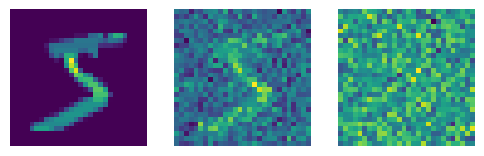

In [5]:
mnist = load_dataset("mnist")
img = np.array(mnist["train"][0]["image"])
img = normalize(img)
img_blurry = img + np.random.normal(size=img.size).reshape(28, 28) * 0.2
img_very_blurry = img + np.random.normal(size=img.size).reshape(28, 28) * 0.8
imgs = [img, img_blurry, img_very_blurry]
show_images(imgs)

An algorithm could look something like this:

- For all pixel values $X_{i,j} \in X$, evaluate the partial derivative $\frac{P(X)-P(X + \partial X_{i,j})}{\partial X_{i,j}}$ or $\frac{\partial P(X)}{\partial X_{i,j}}$. This can also be expressed as $\nabla_X P$
- For some hyperparameter constant $C$ and for all pixel values $X_{i,j} \in X$, $X_{i,j} := X_{i,j} + C \frac{\partial P(X)}{\partial X_{i,j}}$ or, equivalently, $X := X + C \cdot \nabla_X P$
- Repeat until satisfied

In PyTorch, this would look something like:

```python
X = get_image()
# Somewhat unusually, you would incorporate the image as a model
# parameter in order to get auto-differentiation
model = get_nabla_X_of_P_model(X=X)
for _ in range(n_timesteps):
	p_grad = model.forward(X)
	p_grad.backward()
	model.X += C * model.X.grad
```


In fact, we don't have $P(X)$ or $\nabla_X P(X)$ in real life. But we can solve a related problem.

Notice that $\nabla_X P(X)$ provides a direction from blurrier to sharper images. We can train a neural network to de-blur by adding the blur ourselves. The input-output pair would be $\langle image + \epsilon, \epsilon \rangle$ where $\epsilon \sim \mathcal{N}(0, \Sigma)$ and $\Sigma \in \mathbb{R}^{28^2 \times 28^2}$

## An aside, the mathematics

In mathematical parlance, we seek to fit a set of reverse Markov transitions to maximize the likelihood of the model on the training data. Or "minimizing the variational upper bound on the negative log likelihood." Not sure what that mean exactly, but I'll be targetting the mathematical level of myself 6 months ago.

First, we define some terms:

- $X^{(0)}$ is the input data distribution; for example, MNIST digits
- $Q$ and $P$ are probability density functions
- $\beta_t$ is the "noise value" at time t

We can look to physics for inspiration in AI. This paper draws from the thermodynamics to imagine the opposite of a diffusion process: that is, evolving for a high-entropy distribution (like a noisy image) to a clear one.

In the diffusion process, we have a **"forward" **Gaussian Markov process called $Q$ that governs the transition to a noisier distribution. In nature, this is a Guassian distribution:
$$
Q(X^{(t)} | X^{(t-1)}) = \mathcal{N}(X^{(t-1)}\sqrt{1-\beta_t}, I\beta_t)
$$
Note that at $t=0$, we haven't added any noise and $B_0=0$. In fact, there is a simple expected value:

$$
\begin{align}
E\left[\mathcal{N}(X^{(t-1)}\sqrt{1-\beta_t}, I\beta_t)\right]
&= E\left[\mathcal{N}(X^{(t-1)}\sqrt{1-(0)}, I(0)\right]\\
&= E\left[\mathcal{N}(X^{(t-1)}, 0)\right] \\
&= X^{(t-1)}
\end{align}
$$

Furthermore, note that adding noise is a simple process and we generally work with the "analytic" conditional distribution where we all the noise all at once. We'll go over this function later.

The important process to consider, however, is the "backward" Guassian Markov process called $P$


$$
Q(X^{(t)} | X^{(t-1)}) = \mathcal{N}(\square(X^{(t-1)}), \triangle(X^{(t-1)}))
$$

We want a function that maximizes the log-likelihood of this probability distribution on the data. Mathematically, this would involve the integral over the parameters and likelihood. This is mathematically intractable.

(An aside, we use log-likelihood instead of likelihood because it increases monotonically and sums are more numerically stable on computers than products.)

Instead of solving the integral directly, we use the **E**vidence **L**ower **Bo**und. This is a score function of the model that balances maximizing the likelihood of the data under the model with the complexity of the model.
$$
ELBO = E\left[log(P_\theta(X))\right] - KL(q(\theta) || p(\theta))
$$
The expectation maximization term calculates the probability of the data using the PDF $P$. The likelier the data under the model, the lower the loss. Simple.

In general, KL divergence measures the difference between distributions. In our case, it is a loss that should be minimized between the expected (or "variational") weight distribution ($p$) and the actual ("true posterior") distribution ($q$) of the model weights themselves. Basically, we want to see the same distributions in the reverse process that we would see in the forward process.

 The $||$ is a notation for the computation:
$$
KL(q || p) = \int q(\theta)log\left( \frac{q(\theta)}{{p(\theta)}} \right) d\theta
$$
Let's break this down. 

- The log ratio of the point values of $p$ and $q$ at $\theta$ is a measure of the difference at that point
  - If the probability distributions give the same likelihood for $\theta$, the resulting value is 0
  - As $q(\theta)$ goes 0 and $p(\theta)$  goes to 1, the limit of the resulting value diverges to negative infinity
  - As $q(\theta)$ goes 1 and $p(\theta)$  goes to 0, the limit diverges to positive infinity
- $q(\theta)$ is a weight for the integrand

So, in sum, the KL diverenge is a sum of the difference in probability weighted by the probability values of the variational distribution. If the distributions are similar, the KL divergence is small; otherwise, they are large.

See: https://www.assemblyai.com/blog/content/media/2022/05/KL_Divergence.mp4

Interestingly, Ho et al fixes the variance schedule. In turns out, this makes it so that the **covariance matrix is constant, the KL divergence term goes to 0 and we only need to estimate the mean**, i.e.: fit a function to $\square(X^{(t-1)})$.

We can train a model to do so with MSE loss.

This course will demonstrate how to do so from scratch.

Let's begin by running the algorithm.

In [6]:
# |export
TORCH_DEVICE = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available
    else "cpu"
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:10<00:00,  1.41s/it]


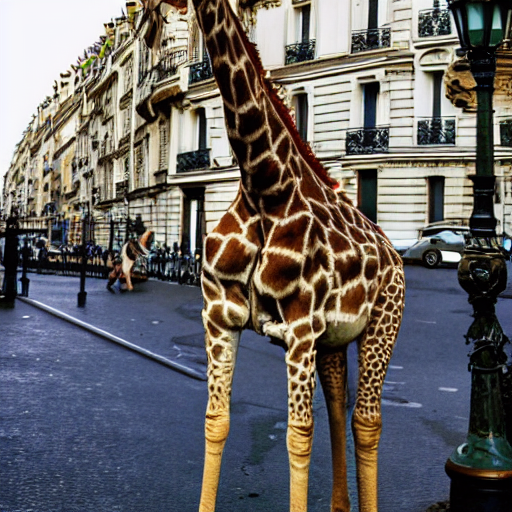

In [7]:
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4")
# Use a simple noising scheduler for the initial draft
pipe.scheduler = LMSDiscreteScheduler(
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    num_train_timesteps=1000,
)
pipe = pipe.to(TORCH_DEVICE)
pipe.enable_attention_slicing()
prompt = "a photo of a giraffe in Paris"
pipe(prompt).images[0]

Now that we see what Stable Diffusion is capable of, we note its three components:

- **Variational Autoencoder**
- **CLIP**
- **Unet**

## Model components
### Variational Autoencoder

Stable Diffusion is a **latent diffusion model.** That means that the model manipulates vectors within the latent space manifold of another model. In this case, that model is a Variational Autoencoder.

In [8]:
vae = pipe.vae

Variational autoencoders are trained to compress vector information into a normal distribution manifold and decompress it with minimal reconstruction loss.

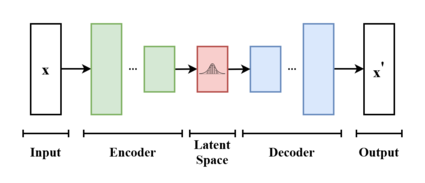

We can visualize the information from a trained VAE.

In [9]:
#| export
def image_from_url(url: str) -> np.array:
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))
    return np.array(image)

In [10]:
#| export
to_tensor = tfms.ToTensor()


VAE_TO_UNET_SCALING_FACTOR = 0.18215


def compress(
    img: Image.Image,  # Input image
    vae: torch.nn.Module,  # VAE
):
    """Project pixels into latent space"""
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    img = to_tensor(img).unsqueeze(0).to(vae.device)
    img = img * 2 - 1  # Note scaling
    with torch.no_grad():
        latents = vae.encode(img)
    return VAE_TO_UNET_SCALING_FACTOR * latents.latent_dist.sample()


def decompress(
    latents: torch.Tensor,  # VAE latents
    vae: torch.nn.Module,  # VAE
    as_pil=True,  # Return a PIL image
    no_grad=True,  # Discard forward gradientss
):
    """Project latents into pixel space"""
    if no_grad:
        with torch.no_grad():
            img = vae.decode(latents / VAE_TO_UNET_SCALING_FACTOR).sample
    else:
        img = vae.decode(latents / VAE_TO_UNET_SCALING_FACTOR).sample
    img = (img / 2 + 0.5).clamp(0, 1)
    # color dimension goes last for matplotlib
    img = img.permute(0, 2, 3, 1)
    if as_pil:
        img = img.cpu().numpy().squeeze()
        img = (img * 255).round().astype("uint8")
        img = Image.fromarray(img)
    return img

'Compression rate: 49.13x'

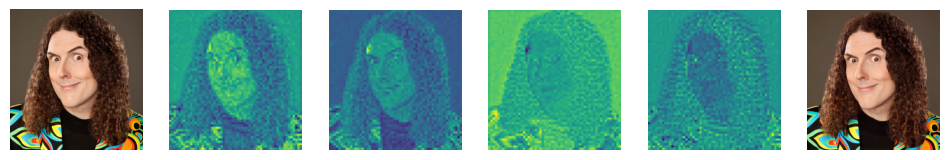

In [11]:
input_ = image_from_url(
    "https://www.perfectduluthday.com/wp-content/uploads/2021/12/Weird_Al_Yankovic_profile.jpg"
)
latents = compress(input_, vae)
output = decompress(latents, vae)
show_images([input_, *latents.squeeze().cpu(), output])
n_params_img = np.product(input_.shape)
n_params_latents = np.product(latents.shape)
f"Compression rate: {n_params_img/n_params_latents:.2f}x"

We get 50x compression with no loss in detail.

Note that, since we're dealing with noise, that noise in the latent space **does not correspond to Gaussian noise in the pixel space**.

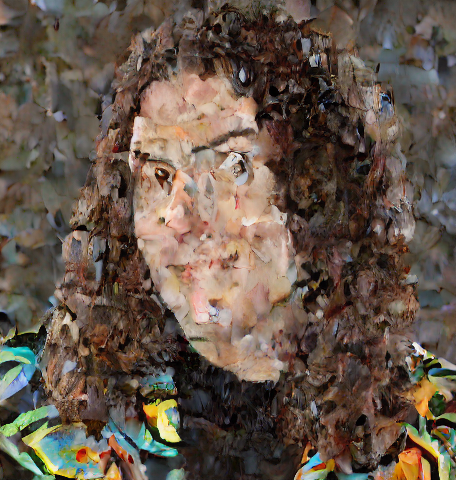

In [12]:
noise = torch.randn(latents.shape, device=latents.device)
noised_latents = latents * 0.6 + noise * 0.4
img = decompress(noised_latents, vae)
img

### U-net

U-nets are the model used for denoising

In [13]:
unet = pipe.unet

We'll get much more into the architecture of the U-net later. For now, know that it is a model with a strong translational equivariance property.

There are two inputs to the model: the prompt and the time.

The time is an index of how noisy the image is. This helps the model to determine how much noise to remove, because the amount of noise added at any given step is non-linear.

In [14]:
scheduler = pipe.scheduler
scheduler

LMSDiscreteScheduler {
  "_class_name": "LMSDiscreteScheduler",
  "_diffusers_version": "0.17.1",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "trained_betas": null,
  "use_karras_sigmas": false
}

[Text(0.5, 0, 'Time'), Text(0, 0.5, '$\\beta$')]

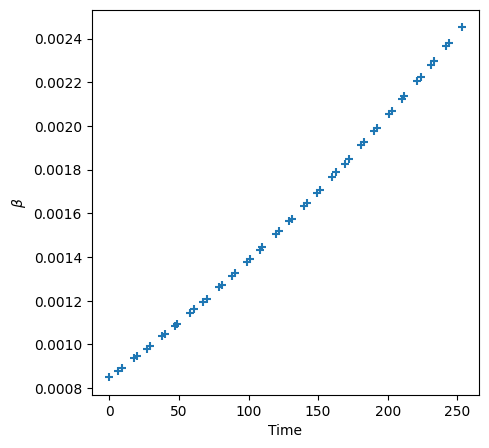

In [15]:
fig, ax = plt.subplots(figsize=(5, 5))
X = timesteps = scheduler.timesteps.to(torch.uint8).cpu().numpy()
Y = scheduler.betas.cpu().numpy()[timesteps]
ax.scatter(X, Y, marker="+")
ax.set(xlabel="Time", ylabel=r"$\beta$")

### CLIP

The other thing we could add to make the problem of de-noising easier is to indicate the image class (1, 2, 3, etc). For a simple class distribution, we could just one hot-encode it.  The input-output pair would then be $\langle \left( image + \epsilon, t, class \right), \epsilon \rangle$.

But we cannot one-hot encode the distribution of images on the internet à la Stable Diffusion. Therefore, we need a more sophisticated encoder: CLIP (**C**onstrastively **L**earned **I**mage **P**airs). This works on the idea that the dot-product between image encoding and text encoding of the *same thing* should be large, while the image encoding and text encoding for *different things* should be small.

We learn this with a neural network contrastively. For a given batch, $B$,  of (image, language) pairs from html `alt` tags:

- Compute the encoding $f_{image}(I_i)$ and $f_{language}(L_i)$ for all $i \in |B|$

- Compute the sum $\text{correctly paried loss} := \Sigma_i^{|B|} f_{image}(I_i) \cdot f_{language}(L_i)$

- Compute the sum

$$
\text{incorrectly paired loss} := \Sigma_i^{|B|} \Sigma_j^{|B|}  \begin{cases}
    f_{image}(I_i) \cdot f_{language}(L_j) & i \neq j\\
    0 & i = j
  \end{cases}
$$

- Final loss = `incorrectly paired loss` - `correctly paired loss`. Note that want the overall loss to be small or negative, so we take the negative of the sum of the correctly paired dot products. This pushes the vectors for correctly paired language image to be in the same subspace, and incorrectly paired counterparts into different subspaces.

![](https://github.com/jeremyadamsfisher/SlowAI/blob/main/images/CLIP.jpg?raw=1)

The `transformers` library has a module for this

In [16]:
tokenizer = pipe.tokenizer
text_encoder = pipe.text_encoder
tokens = tokenizer(prompt, return_tensors="pt").input_ids
tokens

tensor([[49406,   320,  1125,   539,   320, 22826,   530,  3445, 49407]])

We can go backwards like so:

In [17]:
for t in tokens[0, :8]:
    print(f"{t}: {tokenizer.decoder.get(int(t))}")

49406: <|startoftext|>
320: a</w>
1125: photo</w>
539: of</w>
320: a</w>
22826: giraffe</w>
530: in</w>
3445: paris</w>


In [18]:
with torch.no_grad():
    text_embeddings = text_encoder(tokens.to(TORCH_DEVICE)).last_hidden_state
text_embeddings.shape

torch.Size([1, 9, 768])

In fact, this isn't used to directly denoise the image during inference. We use a hack called **C**lassifier **F**ree **G**uidance (CFG), where -- in addition to the latents -- the model is prompted with a null prompt (an unconditional prompt) and and the original prompt.  

See more here: https://www.youtube.com/watch?v=344w5h24-h8

## Putting it together

With these components in mind, we can start to put them together.

In [19]:
#| export
@dataclass
class StableDiffusion:
    tokenizer: CLIPTokenizer
    text_encoder: CLIPTextModel
    scheduler: Any
    unet: UNet2DConditionModel
    vae: AutoencoderKL
    rng = torch.manual_seed(42)

    def embed_prompt(self, prompt: str) -> torch.tensor:
        text_input = self.tokenizer(
            prompt,
            padding="max_length",
            max_length=self.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt",
        )
        with torch.no_grad():
            text_embeddings = self.text_encoder(text_input.input_ids.to(TORCH_DEVICE))
            text_embeddings = text_embeddings[0]
        max_length = text_input.input_ids.shape[-1]
        uncond_input = self.tokenizer(
            [""],
            padding="max_length",
            max_length=max_length,
            return_tensors="pt",
        )
        with torch.no_grad():
            uncond_embeddings = self.text_encoder(
                uncond_input.input_ids.to(TORCH_DEVICE)
            )
            uncond_embeddings = uncond_embeddings[0]
        text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
        return text_embeddings

    def pred_noise(self, prompt_embedding, l, t, guidance_scale):
        latent_model_input = torch.cat([l] * 2)
        # Scale the initial noise by the variance required by the scheduler
        latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)
        with torch.no_grad():
            noise_pred = self.unet(
                latent_model_input, t, encoder_hidden_states=prompt_embedding
            ).sample
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (
            noise_pred_text - noise_pred_uncond
        )
        return noise_pred

    def denoise(
        self, prompt_embedding, l, t, guidance_scale, i, return_noise_pred=False
    ):
        noise_pred = self.pred_noise(prompt_embedding, l, t, guidance_scale)
        l = self.scheduler.step(noise_pred, t, l).prev_sample
        if return_noise_pred:
            return l, noise_pred
        return l

    def init_latents(self):
        l = torch.randn((1, self.unet.config.in_channels, 64, 64), generator=self.rng)
        l = l.to(TORCH_DEVICE)
        l *= self.scheduler.init_noise_sigma
        return l

    def init_schedule(self, n_inference_steps):
        self.scheduler.set_timesteps(n_inference_steps)
        # workaround for ARM Macs where float64's are not supported
        self.scheduler.timesteps = self.scheduler.timesteps.to(torch.float32)
        self.scheduler.timesteps = self.scheduler.timesteps.to(TORCH_DEVICE)
        return self.scheduler

    def __call__(self, prompt, guidance_scale=7.5, n_inference_steps=30, as_pil=False):
        prompt_embedding = self.embed_prompt(prompt)
        l = self.init_latents()
        self.init_schedule(n_inference_steps)
        # Note that the time steps aren't neccesarily 1, 2, 3, etc
        for i, t in tqdm(enumerate(self.scheduler.timesteps), total=n_inference_steps):
            # workaround for ARM Macs where float64's are not supported
            t = t.to(torch.float32).to(TORCH_DEVICE)
            l = self.denoise(prompt_embedding, l, t, guidance_scale, i)
        return decompress(l, self.vae, as_pil=as_pil)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:40<00:00,  1.35s/it]


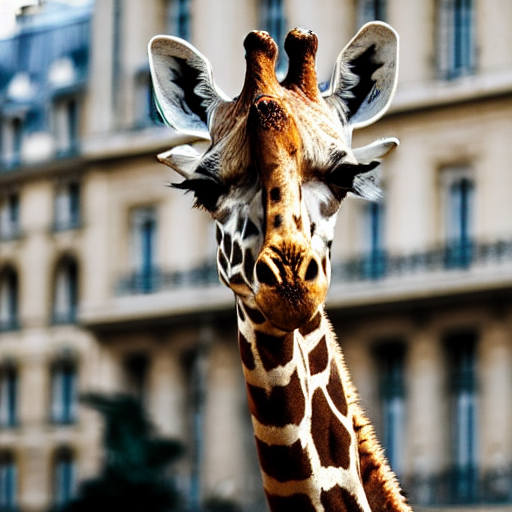

In [20]:
sd = StableDiffusion(
    tokenizer=tokenizer,
    text_encoder=text_encoder,
    scheduler=scheduler,
    unet=unet,
    vae=vae,
)
sd(prompt, n_inference_steps=30, as_pil=True)

## Sampling

There are many ways to sample from Stable Diffusion. The original sampling was a simple numerical differential equation solver (known as the linear multistep solver or LMS): where we take the steps that the gradient suggests with the magnitude of the solver.

It should be noted that this is similar to solving for neural network weights. Therefore, we take a step accourding to the optimizer and wait for convergence.

We can also use the tricks associated with successful neural network training. It is well-understood that the derivative isn't always a good indicator of the loss curvature. We can improve the quality of the right direction by incorporating previous computations of the gradient (i.e., momentum).

Read more about that here: https://stable-diffusion-art.com/samplers/

## Hacking

### Optimizing pixels directly

We are not constrained to using the algorithms as presented to us. This is all just calculus, so we can optimize with respect to arbirary loss functions.

 17%|████████████████████████                                                                                                                        | 5/30 [00:06<00:33,  1.33s/it]

5: arbritrary loss: 40.17461013793945


/Users/jeremiahfisher/miniforge3/envs/slowai/lib/python3.9/site-packages/torch/autograd/__init__.py:303: UserWarning: The operator 'aten::sgn.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
 33%|███████████████████████████████████████████████▋                                                                                               | 10/30 [00:40<01:21,  4.09s/it]

10: arbritrary loss: 27.197010040283203


 50%|███████████████████████████████████████████████████████████████████████▌                                                                       | 15/30 [01:18<01:09,  4.65s/it]

15: arbritrary loss: 21.870607376098633


 67%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 20/30 [02:02<00:53,  5.37s/it]

20: arbritrary loss: 21.79729652404785


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 25/30 [02:42<00:24,  4.96s/it]

25: arbritrary loss: 21.87038230895996


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [03:27<00:00,  6.91s/it]


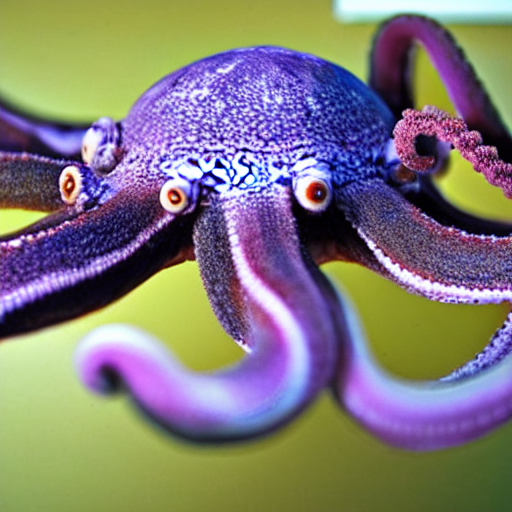

In [21]:
@dataclass
class StableDiffusionWithArbitraryLoss(StableDiffusion):
    loss_f: Callable
    k: float
    periodicity: int = 5

    def denoise(self, prompt_embedding, l, t, guidance_scale, i):
        if i % self.periodicity == 0 and i != 0:
            # Calculate noise as per usual
            noise_pred = self.pred_noise(prompt_embedding, l, t, guidance_scale)

            # Create a copy of the latents that keeps track of the gradients
            l = l.detach().requires_grad_()

            # Take a step all the way towards a predicted x0 and use this to
            # compute the loss
            l_x0 = self.scheduler.step(noise_pred, t, l).pred_original_sample
            image_x0 = decompress(l_x0, self.vae, as_pil=False, no_grad=False)
            loss = self.loss_f(image_x0) * self.k
            print(f"{i}: arbritrary loss: {loss}")

            # Compute the loss gradient with respect to the latents and take
            # a step in that direction
            (grad,) = torch.autograd.grad(loss, l)
            sigma = self.scheduler.sigmas[i]
            l = l.detach() - grad * sigma**2
        else:
            with torch.no_grad():
                noise_pred = self.pred_noise(prompt_embedding, l, t, guidance_scale)

        l = self.scheduler.step(noise_pred, t, l).prev_sample

        return l


def blue_loss(images):
    return torch.abs(images[:, 2] - 0.9).mean()


StableDiffusionWithArbitraryLoss(
    tokenizer=tokenizer,
    text_encoder=text_encoder,
    scheduler=scheduler,
    unet=unet,
    vae=vae,
    loss_f=blue_loss,
    k=75,
    periodicity=5,
)(
    "a photo of an octopus, national geographic, dlsr",
    n_inference_steps=30,
    as_pil=True,
)

Look! Less blue than you would expect for an underwater scene. Cool 😎

### Tinkering with the prompt embedding

We are also not constrained to the text embeddings directly from CLIP. We can take embeddings from different tokens and hack them apart.

In [22]:
prompt = "an adorable photo of a puppy"
tokens_a = tokenizer(prompt, return_tensors="pt").input_ids
for t in tokens_a[0, ...]:
    print(f"{t}: {tokenizer.decoder.get(int(t))}")
text_embeddings_a = text_encoder(tokens_a.to(TORCH_DEVICE)).last_hidden_state
text_embeddings_a.shape

49406: <|startoftext|>
550: an</w>
6298: adorable</w>
1125: photo</w>
539: of</w>
320: a</w>
6829: puppy</w>
49407: <|endoftext|>


torch.Size([1, 8, 768])

In [23]:
prompt = "a adorable photo of a koala"
tokens_b = tokenizer(prompt, return_tensors="pt").input_ids
for t in tokens_b[0, ...]:
    print(f"{t}: {tokenizer.decoder.get(int(t))}")
with torch.no_grad():
    text_embeddings_b = text_encoder(tokens_b.to(TORCH_DEVICE)).last_hidden_state
text_embeddings_b.shape

49406: <|startoftext|>
320: a</w>
6298: adorable</w>
1125: photo</w>
539: of</w>
320: a</w>
36654: koala</w>
49407: <|endoftext|>


torch.Size([1, 8, 768])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:58<00:00,  1.96s/it]


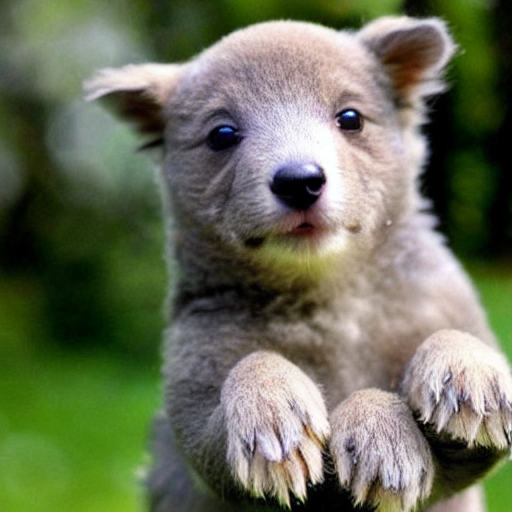

In [24]:
combined_text_embeddings = (text_embeddings_a + text_embeddings_b) / 2


class PuppyKoala(StableDiffusion):
    def embed_prompt(self, _: str) -> torch.tensor:
        global combined_text_embeddings
        _, max_length, _ = combined_text_embeddings.shape
        uncond_input = self.tokenizer(
            [""],
            padding="max_length",
            max_length=max_length,
            return_tensors="pt",
        )
        with torch.no_grad():
            uncond_embeddings = self.text_encoder(
                uncond_input.input_ids.to(TORCH_DEVICE)
            )
            uncond_embeddings = uncond_embeddings[0]
        return torch.cat([uncond_embeddings, combined_text_embeddings])


sd = PuppyKoala(
    tokenizer=tokenizer,
    text_encoder=text_encoder,
    scheduler=scheduler,
    unet=unet,
    vae=vae,
)

sd(prompt, n_inference_steps=30, as_pil=True)

In [25]:
#| hide
import nbdev

nbdev.nbdev_export()